In [1]:
import numpy as np
import pandas as pd
import string
import re
import collections
from num2word import word
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk 
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

from gensim.models import Word2Vec
from time import time 
import multiprocessing
import logging  # logger
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)



from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


# Import Data Set

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train,test],axis=0)

In [3]:
print(train.shape,test.shape,data.shape)

(120000, 3) (7600, 3) (127600, 3)


In [4]:
data.head()

Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...



# Remove Punctuation and Stopwords 

In [5]:
data['Title'] = data['Title'].apply(lambda s: re.sub(r'[^a-z0-9]',' ',s.lower()))
data['Description'] = data['Description'].apply(lambda s: re.sub(r'[^a-z0-9]',' ',s.lower()))

In [6]:
def convert_num_to_word(words):
    result = []
    for w in words:
        if w.isnumeric():
            result.extend(map(lambda x: x.lower(),word(w).split()))
        else:
            result.append(w)
    return result


In [7]:
def remove_stopword(words):
    result = []
    for word in words:
        if word not in STOPWORDS:
            result.append(word)
    return result


In [8]:
def remove_single_character(words):
    result = []
    for word in words:
        if len(word) > 1:
            result.append(word)
    return result  

# Lemmatization

In [9]:
def lemmatization(words):
    lemmatizer = WordNetLemmatizer()
    result = []
    for word in words:
        result.append(lemmatizer.lemmatize(word))
    return result

In [10]:

data['Title'] = data['Title'].str.split().apply(convert_num_to_word)
data['Description'] = data['Description'].str.split().apply(convert_num_to_word)
data['Title'] = data['Title'].apply(remove_stopword)
data['Description'] = data['Description'].apply(remove_stopword)
data['Title'] = data['Title'].apply(remove_single_character)
data['Description'] = data['Description'].apply(remove_single_character)
data['Title'] = data['Title'].apply(lemmatization)
data['Description'] = data['Description'].apply(lemmatization)


# Combine Title and Description

In [11]:
data['Documents'] = data['Title'] + data['Description']

In [12]:
data['Word Count'] = data['Documents'].apply(lambda x: len(x))

In [13]:
data.head()

Class Index                                              Title  \
0            3       [wall, st, bear, claw, back, black, reuters]   
1            3  [carlyle, look, toward, commercial, aerospace,...   
2            3     [oil, economy, cloud, stock, outlook, reuters]   
3            3  [iraq, halt, oil, export, main, southern, pipe...   
4            3  [oil, price, soar, time, record, posing, new, ...   

                                         Description  \
0  [reuters, short, seller, wall, street, dwindli...   
1  [reuters, private, investment, firm, carlyle, ...   
2  [reuters, soaring, crude, price, plus, worry, ...   
3  [reuters, authority, halted, oil, export, flow...   
4  [afp, tearaway, world, oil, price, toppling, r...   

                                           Documents  Word Count  
0  [wall, st, bear, claw, back, black, reuters, r...          18  
1  [carlyle, look, toward, commercial, aerospace,...          27  
2  [oil, economy, cloud, stock, outlook, reuters,...          24  
3  [iraq, halt, oil, export, main, southern, pipe...          28  
4  [oil, price, soar, time, record, posing, new, ...          30

In [14]:
data.dtypes

Class Index     int64
Title          object
Description    object
Documents      object
Word Count      int64
dtype: object

# Drop Title & Description

In [15]:
data['Documents_Copy'] = data['Documents']

data['Documents_Copy'] = data['Documents_Copy'].apply(lambda x: ' '.join(map(str,x)))
data.drop(['Title','Description'],axis=1,inplace=True)
data.head()

Class Index                                          Documents  Word Count  \
0            3  [wall, st, bear, claw, back, black, reuters, r...          18   
1            3  [carlyle, look, toward, commercial, aerospace,...          27   
2            3  [oil, economy, cloud, stock, outlook, reuters,...          24   
3            3  [iraq, halt, oil, export, main, southern, pipe...          28   
4            3  [oil, price, soar, time, record, posing, new, ...          30   

                                      Documents_Copy  
0  wall st bear claw back black reuters reuters s...  
1  carlyle look toward commercial aerospace reute...  
2  oil economy cloud stock outlook reuters reuter...  
3  iraq halt oil export main southern pipeline re...  
4  oil price soar time record posing new menace u...

# Create Features
count: noun phrase, noun, verb, adjective

In [16]:
data['Noun Phrases'] = data['Documents_Copy'].apply(lambda x: len(TextBlob(x).noun_phrases))

In [17]:
data['Tags'] = data['Documents_Copy'].apply(lambda t: collections.Counter(tag for word,tag in TextBlob(t).tags))

In [18]:
# pos tag list https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/

data['Noun Count'] = data['Tags'].apply(lambda d: d.get('NN',0)+d.get('NNS',0)+d.get('NNP',0)+d.get('NNPS',0))
data['Adjective Count'] = data['Tags'].apply(lambda d: d.get('JJ',0)+d.get('JJR',0)+d.get('JJS',0))
data['Verb Count'] = data['Tags'].apply(lambda d: d.get('VB',0)+d.get('VBD',0)+d.get('VBG',0)+d.get('VBN',0)+d.get('VBP',0)+d.get('VBZ',0))

In [19]:
data.head()

Class Index                                          Documents  Word Count  \
0            3  [wall, st, bear, claw, back, black, reuters, r...          18   
1            3  [carlyle, look, toward, commercial, aerospace,...          27   
2            3  [oil, economy, cloud, stock, outlook, reuters,...          24   
3            3  [iraq, halt, oil, export, main, southern, pipe...          28   
4            3  [oil, price, soar, time, record, posing, new, ...          30   

                                      Documents_Copy  Noun Phrases  \
0  wall st bear claw back black reuters reuters s...             4   
1  carlyle look toward commercial aerospace reute...             5   
2  oil economy cloud stock outlook reuters reuter...             5   
3  iraq halt oil export main southern pipeline re...             3   
4  oil price soar time record posing new menace u...             5   

                                                Tags  Noun Count  \
0  {'NN': 10, 'RB': 1, 'JJ': 3, 'NNS': 2, 'VBP': ...          12   
1  {'JJ': 4, 'NN': 13, 'IN': 1, 'NNS': 2, 'VBG': ...          15   
2  {'NN': 13, 'NNS': 4, 'VBG': 1, 'JJ': 4, 'CC': ...          17   
3  {'NN': 17, 'JJ': 6, 'NNS': 2, 'VBN': 1, 'VBD': 2}          19   
4  {'NN': 16, 'VB': 1, 'VBG': 2, 'JJ': 9, 'RB': 1...          16   

   Adjective Count  Verb Count  
0                3           2  
1                4           3  
2                4           2  
3                6           3  
4                9           3

In [20]:
#data['Documents'] = data['Documents'].str.split(" ")

In [21]:
data = data.drop('Documents_Copy', axis=1)

data.head()


Class Index                                          Documents  Word Count  \
0            3  [wall, st, bear, claw, back, black, reuters, r...          18   
1            3  [carlyle, look, toward, commercial, aerospace,...          27   
2            3  [oil, economy, cloud, stock, outlook, reuters,...          24   
3            3  [iraq, halt, oil, export, main, southern, pipe...          28   
4            3  [oil, price, soar, time, record, posing, new, ...          30   

   Noun Phrases                                               Tags  \
0             4  {'NN': 10, 'RB': 1, 'JJ': 3, 'NNS': 2, 'VBP': ...   
1             5  {'JJ': 4, 'NN': 13, 'IN': 1, 'NNS': 2, 'VBG': ...   
2             5  {'NN': 13, 'NNS': 4, 'VBG': 1, 'JJ': 4, 'CC': ...   
3             3  {'NN': 17, 'JJ': 6, 'NNS': 2, 'VBN': 1, 'VBD': 2}   
4             5  {'NN': 16, 'VB': 1, 'VBG': 2, 'JJ': 9, 'RB': 1...   

   Noun Count  Adjective Count  Verb Count  
0          12                3           2  
1          15                4           3  
2          17                4           2  
3          19                6           3  
4          16                9           3

# Word Embeddings using Word2Vec algorithm

In [30]:
cores = multiprocessing.cpu_count()

# initializing word2vec model
model = Word2Vec(min_count=20,
                     window=2, # window size for context 
                     vector_size=100,  # no of features 
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

INFO - 11:15:16: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.03)', 'datetime': '2021-04-27T11:15:16.664117', 'gensim': '4.0.1', 'python': '3.8.4 (v3.8.4:dfa645a65e, Jul 13 2020, 10:45:06) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [31]:
t = time()

# build vocabulary
model.build_vocab(data['Documents'], progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 11:15:16: collecting all words and their counts
INFO - 11:15:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 11:15:16: PROGRESS: at sentence #10000, processed 282957 words, keeping 19013 word types
INFO - 11:15:16: PROGRESS: at sentence #20000, processed 562790 words, keeping 26392 word types
INFO - 11:15:16: PROGRESS: at sentence #30000, processed 841031 words, keeping 31412 word types
INFO - 11:15:16: PROGRESS: at sentence #40000, processed 1119923 words, keeping 35417 word types
INFO - 11:15:17: PROGRESS: at sentence #50000, processed 1398898 words, keeping 38849 word types
INFO - 11:15:17: PROGRESS: at sentence #60000, processed 1679406 words, keeping 42071 word types
INFO - 11:15:17: PROGRESS: at sentence #70000, processed 1961214 words, keeping 44895 word types
INFO - 11:15:17: PROGRESS: at sentence #80000, processed 2242166 words, keeping 47523 word types
INFO - 11:15:17: PROGRESS: at sentence #90000, processed 2518495 words, keeping 50167 wor

Time to build vocab: 0.02 mins


In [32]:
t = time()

#train word2vec model 
model.train(data['Documents'], total_examples=model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 11:15:17: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 12051 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2', 'datetime': '2021-04-27T11:15:17.845763', 'gensim': '4.0.1', 'python': '3.8.4 (v3.8.4:dfa645a65e, Jul 13 2020, 10:45:06) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
INFO - 11:15:18: EPOCH 1 - PROGRESS: at 50.87% examples, 1022083 words/s, in_qsize 12, out_qsize 1
INFO - 11:15:19: worker thread finished; awaiting finish of 6 more threads
INFO - 11:15:19: worker thread finished; awaiting finish of 5 more threads
INFO - 11:15:19: worker thread finished; awaiting finish of 4 more threads
INFO - 11:15:19: worker thread finished; awaiting finish of 3 more threads
INFO - 11:15:19: worker thread finished; awaiting finish of 2 more threads
INFO - 11:15:19: worker thread finished; awaiting finish of 1 more threads
INFO - 11:15:19: worker thread finished; awaiting finish of 0 m

Time to train the model: 1.11 mins


In [36]:
# save model
model.save('model.bin')

INFO - 11:16:24: Word2Vec lifecycle event {'fname_or_handle': 'model.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-04-27T11:16:24.691489', 'gensim': '4.0.1', 'python': '3.8.4 (v3.8.4:dfa645a65e, Jul 13 2020, 10:45:06) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'saving'}
INFO - 11:16:24: not storing attribute cum_table
INFO - 11:16:24: saved model.bin


# Word Embedding Space Visualization using TSNE

In [37]:
#news categories 
category = ['world','business','science','sport']  

embedding_clusters = []
word_clusters = []
for word in category:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=25):  
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [38]:
# tsne(t-distributed stochastic neighbor embedding) - nonlinearity dimensionality reduction

tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_2d = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [39]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')   #workaround to avoid matplotlib warnings 

def tsne_plot(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(12, 12))
    plt.title('Word Embedding Space Visualization using TSNE')
    colors = cm.gist_rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', size=8)
    plt.legend(title="Category", loc='upper left', title_fontsize=12)
    plt.show()


tsne_plot(category, embeddings_2d, word_clusters)

# Feature Extraction (word2vec)

Base line number of features = 100

In [40]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.wv.index_to_key)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model.wv[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(words, model, num_features):
    """
    Calculate average feature vectors for all headlines 
    """
    counter = 0
    feature_vecs = np.zeros((len(words),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for word in words:
        feature_vecs[counter] = make_feature_vec(word, model, num_features)
        counter = counter + 1
    return feature_vecs

In [41]:
word2vec = get_avg_feature_vecs(data['Documents'], model, 100)

In [45]:
# remove instances in test set that could not be represented as feature vectors
nan_indices = list({x for x,y in np.argwhere(np.isnan(word2vec))})
if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    word2vec = np.delete(word2vec, nan_indices, axis=0)
    word2vec.drop(data.iloc[nan_indices, :].index, axis=0, inplace=True)
    assert word2vec.shape[0] == len(data)

In [48]:
w2v = pd.DataFrame(word2vec)

data.reset_index(drop=True, inplace=True)
w2v.reset_index(drop=True, inplace=True)
#df = pd.concat([df1, df2], axis=1)
w2v = pd.concat([data[['Class Index','Word Count','Noun Phrases','Noun Count',
                                         'Adjective Count','Verb Count']],w2v],axis=1)

w2v

Class Index  Word Count  Noun Phrases  Noun Count  Adjective Count  \
0                 3          18             4          12                3   
1                 3          27             5          15                4   
2                 3          24             5          17                4   
3                 3          28             3          19                6   
4                 3          30             5          16                9   
...             ...         ...           ...         ...              ...   
127595            1          19             3           9                4   
127596            2          41             7          17                9   
127597            2          20             5           9                3   
127598            3          25             4          14                4   
127599            3          20             4           8                4   

        Verb Count         0         1         2         3  ...        90  \
0                2  0.157802  0.262879 -0.448297 -0.701026  ... -0.336607   
1                3 -0.043006  0.058823 -0.290017 -0.418483  ...  0.226791   
2                2  0.136613 -0.652272 -0.946852 -1.332885  ... -0.513650   
3                3 -0.109586 -0.321831 -0.762077 -0.341336  ... -0.333672   
4                3  0.114433 -0.178190 -0.474649 -0.838190  ... -0.187440   
...            ...       ...       ...       ...       ...  ...       ...   
127595           5  0.497404  0.123658 -0.226125 -0.380785  ... -0.535057   
127596          10 -0.459639 -0.099182 -0.148294 -0.342488  ...  0.019707   
127597           3 -0.499283  0.056572 -0.252855 -0.124598  ... -0.019137   
127598           4  0.525825 -0.306397 -0.303815 -0.422435  ... -0.359170   
127599           5 -0.047924  0.437919 -0.304321 -0.369495  ...  0.614316   

              91        92        93        94        95        96        97  \
0       0.043026 -0.113095 -0.202309 -0.265302 -0.055972  0.633051  0.119429   
1       0.347388  0.171794 -0.105393  0.330228 -0.227835  0.203563  0.041699   
2       0.963665 -0.465611 -0.408781 -0.627235  0.610165  0.060002 -0.053505   
3       0.512828 -0.880786 -0.734689 -0.199295 -0.146432 -0.583720 -0.141340   
4       0.475409 -0.591695 -0.440951 -0.312417  0.140083 -0.188024  0.063946   
...          ...       ...       ...       ...       ...       ...       ...   
127595 -0.113314  0.103898  0.784250 -0.051388 -0.040351 -0.462834  0.342662   
127596  0.342486  0.197577  0.087238  0.180461 -0.091379  0.381946  0.354144   
127597  0.183066  0.064171  0.046570 -0.205715 -0.641405  0.055976  0.658472   
127598  0.510908  0.178271  0.285510  0.196107 -0.139116 -0.427791  0.295889   
127599  0.374460  0.332703  0.230366 -0.335533  0.104179  0.308471  0.665623   

              98        99  
0       0.111313 -0.027549  
1       0.253005  0.007421  
2      -0.324398 -0.223052  
3       0.388959 -0.214727  
4       0.133643  0.126098  
...          ...       ...  
127595 -0.250100 -0.094541  
127596 -0.281229 -0.222247  
127597 -0.263033 -0.358176  
127598 -0.578516  0.025317  
127599  0.584976 -0.984187  

[127600 rows x 106 columns]

In [79]:
# X dataframe 
X = w2v.drop(['Class Index'],axis=1) 
# y series
y = w2v['Class Index']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

# Classifications Models

# Random Forest Classifier

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

start_time = time()

print("Fitting a random forest to labeled training data...")
#forest = forest.fit(trainDataVecs, train_words['Class Index'])
forest = forest.fit(X_train, y_train)

rf_tt = round((time() - start_time) / 60, 2)

print('Time to train Random Forest Model: {} mins'.format(rf_tt))

Fitting a random forest to labeled training data...
Time to train Random Forest Model: 2.11 mins


In [53]:
start_time = time()

rf_result = forest.predict(X_test)

rf_pt = round((time() - start_time) / 60, 2)

print('Time taken for label prediction using Random Forest model: {} mins'.format(rf_pt))

Time taken for label prediction using Random Forest model: 0.02 mins


In [54]:
rf = round(accuracy_score(y_test, rf_result)*100,3)

In [55]:
print(classification_report(y_test, rf_result))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90      9446
           2       0.94      0.97      0.95      9510
           3       0.87      0.87      0.87      9711
           4       0.87      0.86      0.87      9613

    accuracy                           0.90     38280
   macro avg       0.90      0.90      0.90     38280
weighted avg       0.90      0.90      0.90     38280



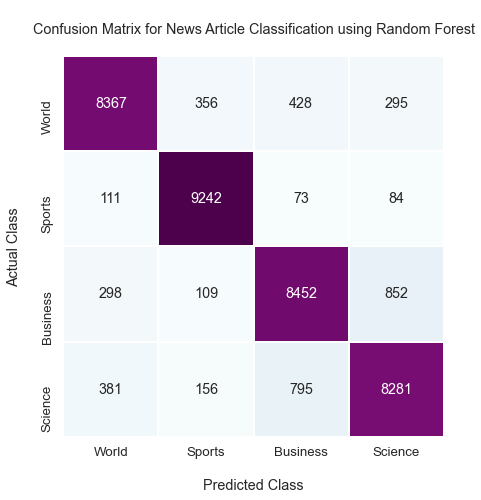

In [56]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns

sns.set(font_scale=1.2)
cof=confusion_matrix(y_test, rf_result)
cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
plt.figure(figsize=(7,7))

sns.heatmap(cof, cmap="BuPu",linewidths=1, annot=True,square=True,cbar=False,fmt='d',
            xticklabels=['World','Sports','Business','Science'],
            yticklabels=['World','Sports','Business','Science'])
plt.xlabel("\nPredicted Class");
plt.ylabel("Actual Class\n");

plt.title("\nConfusion Matrix for News Article Classification using Random Forest\n");

# Naive Bayes Classsifier

In [57]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB


# instantiate the model
gnb = GaussianNB()

print("Fitting a Naive Bayes to labeled training data...")

start_time = time()

# fit the model
gnb.fit(X_train, y_train)

nb_tt = round((time() - start_time) / 60, 2)

print('Time to train Naive Bayes Model: {} mins'.format(nb_tt))

Fitting a Naive Bayes to labeled training data...
Time to train Naive Bayes Model: 0.0 mins


In [58]:
start_time = time()

nb_result = gnb.predict(X_test)

nb_pt = round((time() - start_time) / 60, 2)

print('Time taken for label prediction using Naive Bayes model: {} mins'.format(nb_pt))

Time taken for label prediction using Naive Bayes model: 0.0 mins


In [59]:
nb = round(accuracy_score(y_test, nb_result)*100,3)

In [60]:
print(classification_report(y_test, nb_result))

              precision    recall  f1-score   support

           1       0.84      0.88      0.86      9446
           2       0.90      0.95      0.92      9510
           3       0.84      0.80      0.82      9711
           4       0.83      0.78      0.81      9613

    accuracy                           0.85     38280
   macro avg       0.85      0.85      0.85     38280
weighted avg       0.85      0.85      0.85     38280



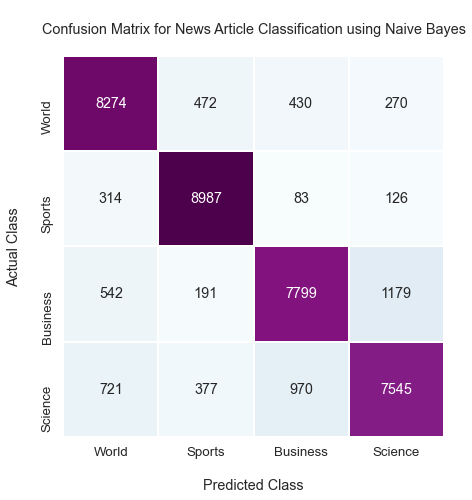

In [61]:
sns.set(font_scale=1.2)
cof=confusion_matrix(y_test, nb_result)
cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
plt.figure(figsize=(7,7))

sns.heatmap(cof, cmap="BuPu",linewidths=1, annot=True,square=True,cbar=False,fmt='d',
            xticklabels=['World','Sports','Business','Science'],
            yticklabels=['World','Sports','Business','Science'])
plt.xlabel("\nPredicted Class");
plt.ylabel("Actual Class\n");

plt.title("\nConfusion Matrix for News Article Classification using Naive Bayes\n");

# Logistic Regression Classifier

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
logit = LogisticRegression()

print("Fitting a Logistic Regression model to labeled training data...")

start_time = time()

logit.fit(X_train,y_train)

lr_tt = round((time() - start_time) / 60, 2)

print('Time to train Logistic Regression Model: {} mins'.format(lr_tt))


Fitting a Logistic Regression model to labeled training data...
Time to train Logistic Regression Model: 0.05 mins


In [64]:
start_time = time()

lr_result = logit.predict(X_test)

lr_pt = round((time() - start_time) / 60, 2)

print('Time taken for label prediction using Logistic Regression model: {} mins'.format(lr_pt))

Time taken for label prediction using Logistic Regression model: 0.0 mins


In [65]:
lr = round(accuracy_score(y_test, lr_result)*100,3)

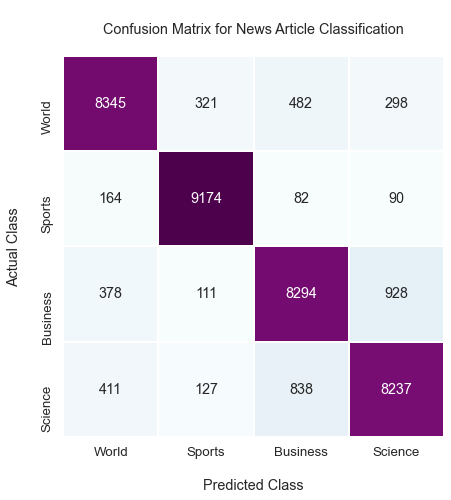

In [66]:
sns.set(font_scale=1.2)
cof=confusion_matrix(y_test, lr_result)
cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
plt.figure(figsize=(7,7))

sns.heatmap(cof, cmap="BuPu",linewidths=1, annot=True,square=True,cbar=False,fmt='d',
            xticklabels=['World','Sports','Business','Science'],
            yticklabels=['World','Sports','Business','Science'])
plt.xlabel("\nPredicted Class");
plt.ylabel("Actual Class\n");

plt.title("\nConfusion Matrix for News Article Classification\n");

# SVM Classifier

In [67]:
from sklearn.svm import SVC

In [68]:
svc = SVC()

print("Fitting a SVM model to labeled training data...")

start_time = time()

svc.fit(X_train,y_train)

svm_tt = round((time() - start_time) / 60, 2)

print('Time to train SVM mode: {} mins'.format(svm_tt))

Fitting a SVM model to labeled training data...
Time to train SVM mode: 7.35 mins


In [69]:
start_time = time()

svm_result = svc.predict(X_test)

svm_pt = round((time() - start_time) / 60, 2)

print('Time taken for label prediction using SVM model: {} mins'.format(svm_pt))

Time taken for label prediction using SVM model: 2.72 mins


In [70]:
svm = round(accuracy_score(y_test, svm_result)*100,3)

In [71]:
sns.set(font_scale=1.2)
cof=confusion_matrix(y_test, svm_result)
cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
plt.figure(figsize=(7,7))

sns.heatmap(cof, cmap="BuPu",linewidths=1, annot=True,square=True,cbar=False,fmt='d',
            xticklabels=['World','Sports','Business','Science'],
            yticklabels=['World','Sports','Business','Science'])
plt.xlabel("\nPredicted Class");
plt.ylabel("Actual Class\n");

plt.title("\nConfusion Matrix for News Article Classification\n");

# Comparison of models (Accuracy)

In [72]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic', 'SVM']
Accuracy=[rf,nb,lr,svm]
ax.bar(Models,Accuracy,color=["lightgreen","pink", "skyblue", "lightyellow"]);
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()-5.5, str(round(i.get_height(),2))+'%', fontsize=15, color='black')
plt.title('Comparison of Classification Models trained using word2vec + grammatical + syntax features \n');
plt.ylabel('Accuracy\n');
plt.xlabel('\nClassification Models');

plt.show();

# Comparison of models (Training Time)

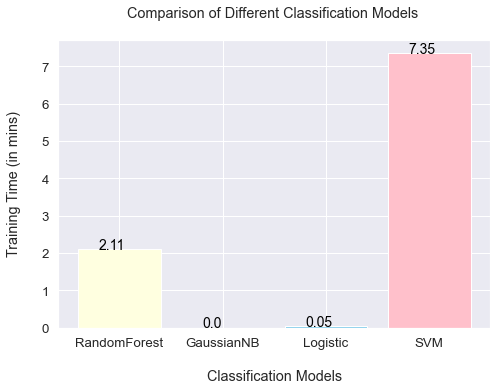

In [73]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic', 'SVM']
TrainingTime=[rf_tt,nb_tt,lr_tt,svm_tt]
ax.bar(Models,TrainingTime,color=["lightyellow","lightgreen", "skyblue", "pink"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models \n');
plt.ylabel('Training Time (in mins)\n');
plt.xlabel('\nClassification Models');

plt.show();

# Comparison of models (Label Classification Time)

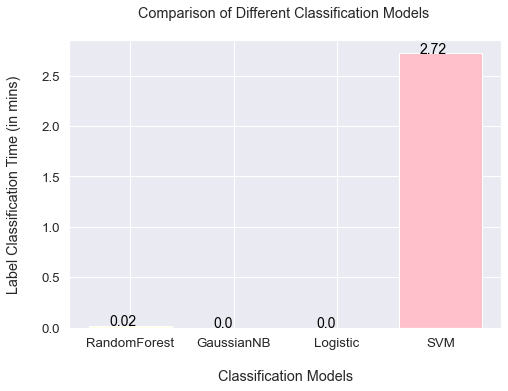

In [74]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic', 'SVM']
PredictTime=[rf_pt,nb_pt,lr_pt,svm_pt]
ax.bar(Models,PredictTime,color=["lightyellow","lightgreen", "skyblue", "pink"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models \n');
plt.ylabel('Label Classification Time (in mins)\n');
plt.xlabel('\nClassification Models');

plt.show();

# Model Training & Evaluation using Cross-Validation approach

Logistic Regression

In [80]:
lr = LogisticRegression(solver='newton-cg')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lr_acc = []

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train.iloc[train_index], X_train.iloc[vaild_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[vaild_index]
    lr.fit(x_t, y_t)
    lr_acc.append(lr.score(x_v, y_v))
    
    

In [82]:
print(lr_acc)

[0.8945364979847739, 0.890450067174205, 0.8910658307210031, 0.8916256157635468, 0.8920174652933274]


In [84]:
print(np.mean(lr_acc))

0.8919390953873713


Random Forest 

In [85]:
rf = RandomForestClassifier()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
rf_acc = []

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train.iloc[train_index], X_train.iloc[vaild_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[vaild_index]
    rf.fit(x_t, y_t)
    rf_acc.append(rf.score(x_v, y_v))

In [86]:
print(rf_acc)

[0.8980071652485445, 0.8951522615315719, 0.8963278101209136, 0.8960479175996418, 0.8952642185400806]


In [87]:
print(np.mean(rf_acc))

0.8961598746081505


Naive Bayes

In [88]:
gnb = GaussianNB()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
gnb_acc = []

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train.iloc[train_index], X_train.iloc[vaild_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[vaild_index]
    gnb.fit(x_t, y_t)
    gnb_acc.append(gnb.score(x_v, y_v))

In [89]:
print(gnb_acc)

[0.8564711150918047, 0.8505933721450963, 0.8523287057769816, 0.8579265562024183, 0.8541200179131213]


In [90]:
print(np.mean(gnb_acc))

0.8542879534258845


SVM

In [91]:
svc = SVC()

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
svc_acc = []

for train_index, vaild_index in skf.split(X_train,y_train):
    x_t, x_v = X_train.iloc[train_index], X_train.iloc[vaild_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[vaild_index]
    svc.fit(x_t, y_t)
    svc_acc.append(svc.score(x_v, y_v))

In [92]:
print(svc_acc)

[0.8914464845499328, 0.8874160322436184]


In [93]:
print(np.mean(svc_acc))

0.8894312583967756


Model Evaluation

In [102]:
from sklearn.preprocessing import OneHotEncoder

y_test = y_test.to_numpy()
y_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_test,y_pred)
lr_recall = recall_score(y_test,y_pred,average='macro')
lr_precision = precision_score(y_test,y_pred,average='macro')
lr_f1 = f1_score(y_test,y_pred,average='macro')

y_pred_roc = OneHotEncoder().fit_transform(y_pred.reshape(-1, 1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
lr_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [103]:
y_pred = gnb.predict(X_test)

gnb_acc = accuracy_score(y_test,y_pred)
gnb_recall = recall_score(y_test_roc,y_pred_roc,average='macro')
gnb_precision = precision_score(y_test_roc,y_pred_roc,average='macro')
gnb_f1 = f1_score(y_test_roc,y_pred_roc,average='macro')

y_pred_roc = OneHotEncoder().fit_transform(y_pred.reshape(-1, 1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
gnb_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')
# The multiclass and multilabel cases expect a shape (n_samples, n_classes)

In [104]:
y_pred = svc.predict(X_test)

svc_acc = accuracy_score(y_test,y_pred)
svc_recall = recall_score(y_test,y_pred,average='macro')
svc_precision = precision_score(y_test,y_pred,average='macro')
svc_f1 = f1_score(y_test,y_pred,average='macro')

y_pred_roc = OneHotEncoder().fit_transform(y_pred.reshape(-1, 1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
svc_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [105]:
y_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test,y_pred)
rf_recall = recall_score(y_test,y_pred,average='macro')
rf_precision = precision_score(y_test,y_pred,average='macro')
rf_f1 = f1_score(y_test,y_pred,average='macro')

y_pred_roc = OneHotEncoder().fit_transform(y_pred.reshape(-1, 1)).toarray()
y_test_roc = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
rf_roc = roc_auc_score(y_test_roc,y_pred_roc,multi_class='ovo')

In [106]:
print("Logistic Regression: ",lr_acc,lr_recall,lr_precision,lr_f1,lr_roc)
print("Naive Bayes: ", gnb_acc,gnb_recall,gnb_precision,gnb_f1,gnb_roc)
print("Support Vector Machine: ", svc_acc,svc_recall,svc_precision,svc_f1,svc_roc)
print("Random Forest: ", rf_acc,rf_recall,rf_precision,rf_f1,rf_roc)

Logistic Regression:  0.8940438871473354 0.8942404743865096 0.8942348358292537 0.8941227648054244 0.9294527838782625
Naive Bayes:  0.8519853709508882 0.8942404743865096 0.8942348358292537 0.8941227648054244 0.9014561767096279
Support Vector Machine:  0.8898380355276907 0.8900482468805495 0.8898518551101414 0.8898194746948436 0.9266557839162346
Random Forest:  0.8947753396029258 0.8949699802461227 0.8948865942559427 0.894722555674586 0.9299405800255501


# Results

In [107]:
results = pd.DataFrame([[lr_acc,lr_recall,lr_precision,lr_f1,lr_roc],
                        [gnb_acc,gnb_recall,gnb_precision,gnb_f1,gnb_roc],
                        [svc_acc,svc_recall,svc_precision,svc_f1,svc_roc],
                        [rf_acc,rf_recall,rf_precision,rf_f1,rf_roc]],
                       columns=['accuracy','recall','precision','fl-score','roc_auc'], 
                       index=["Logistic Regression","Naive Bayes","Support Vector Machine","Random Forest"])

In [108]:
results

accuracy    recall  precision  fl-score   roc_auc
Logistic Regression     0.894044  0.894240   0.894235  0.894123  0.929453
Naive Bayes             0.851985  0.894240   0.894235  0.894123  0.901456
Support Vector Machine  0.889838  0.890048   0.889852  0.889819  0.926656
Random Forest           0.894775  0.894970   0.894887  0.894723  0.929941

In [109]:
results.to_csv('word2vec_results.csv')